## Import Library

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg19 import VGG19

## Load Dataset

In [ ]:
import os
import shutil

# mengakses dataset awal
data_dir = '/content/cityscapes_data/cityscapes_data'

# membuat informasi class
all_class = {'train':{},'valid':{}}
for cl in os.listdir(data_dir):
    items = os.listdir(f'{data_dir}/{cl}')
    test_count = int(0.2*(len(items)))
    all_class['train'][cl] = items[test_count:]
    all_class['valid'][cl] = items[:test_count]

In [ ]:
train_folder="/content/cityscapes_data/cityscapes_data/train"
valid_folder="/content/cityscapes_data/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder))
num_of_testing_samples = len(os.listdir(valid_folder))

## load image and segmentation

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)

    image = img[:,:256]
    mask = img[:,256:]

    return image, mask

In [ ]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In [ ]:
def give_color_to_seg_img(seg, n_classes=13):

    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)

                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

## Visual data sample

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

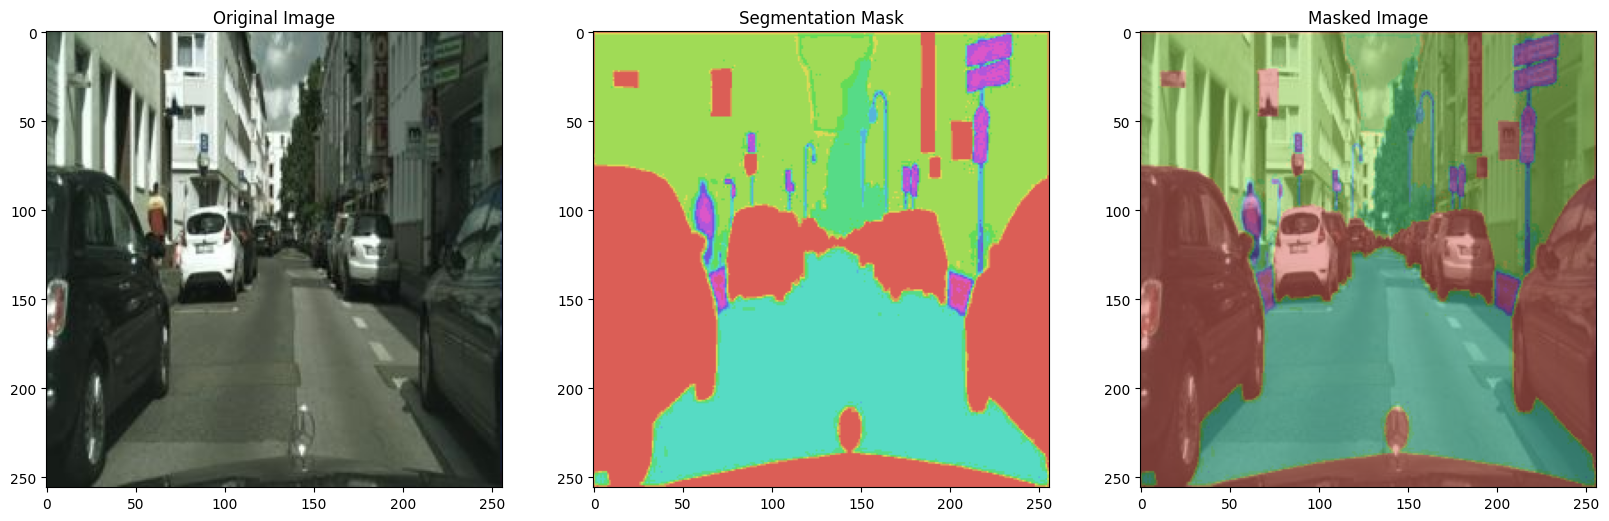

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

## Segmentation Model

In [ ]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output

    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)

    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)

    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)

    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(width, height, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model = fcn(vgg, fcn8 = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

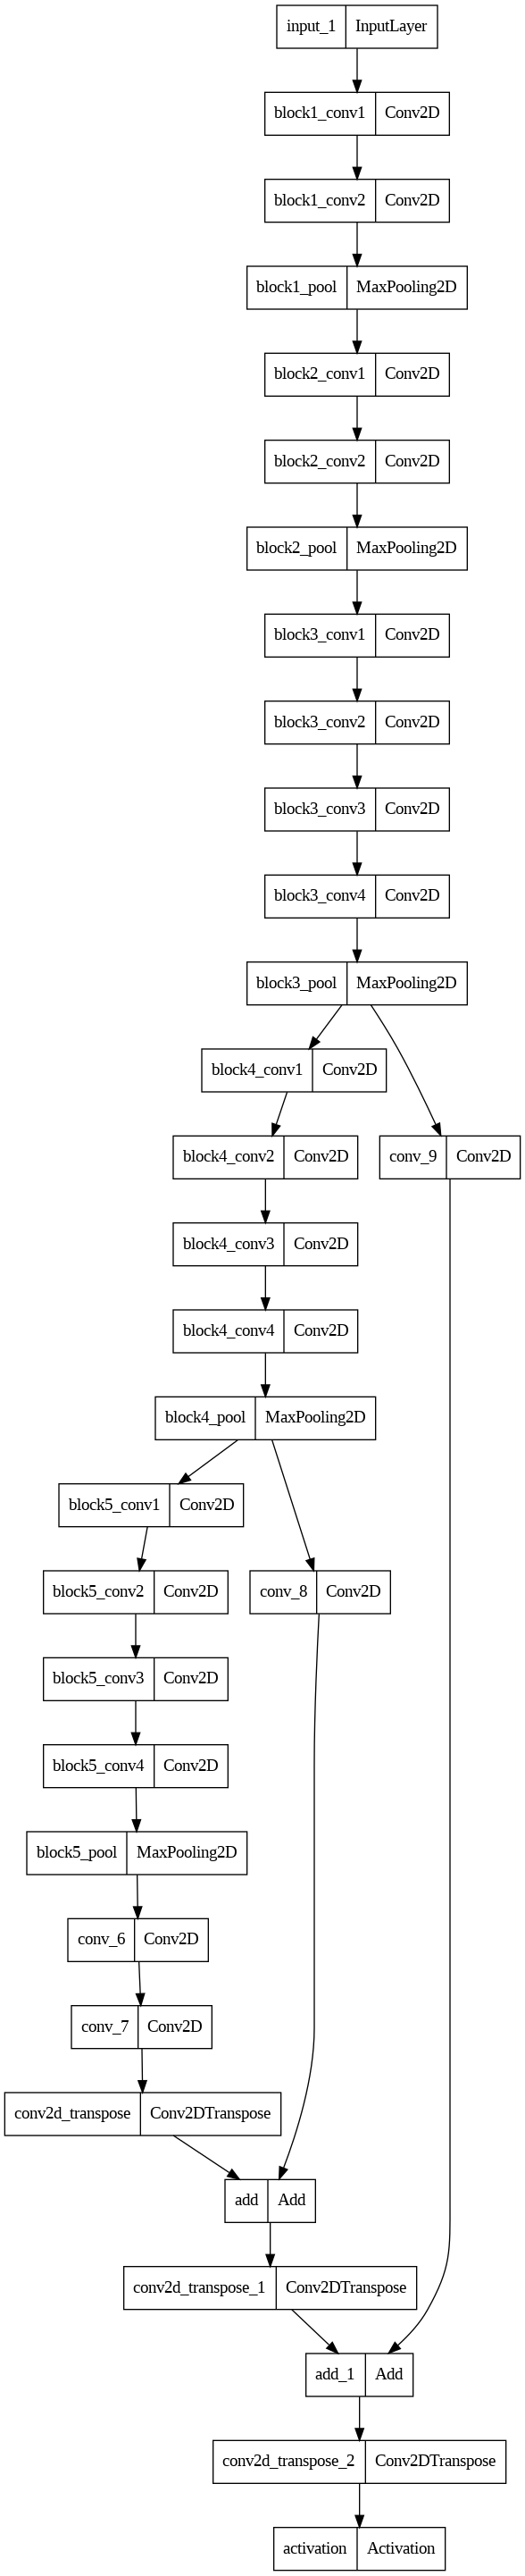

In [ ]:
plot_model(model)

## Train our Model

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=2, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

Epoch 1/10


<ipython-input-56-e34adbc86321>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,


149/297 [==============>...............] - ETA: 59:27 - loss: 2.2265 - accuracy: 0.2565

In [ ]:
model.load_weights("best-model-vgg.hdf5")

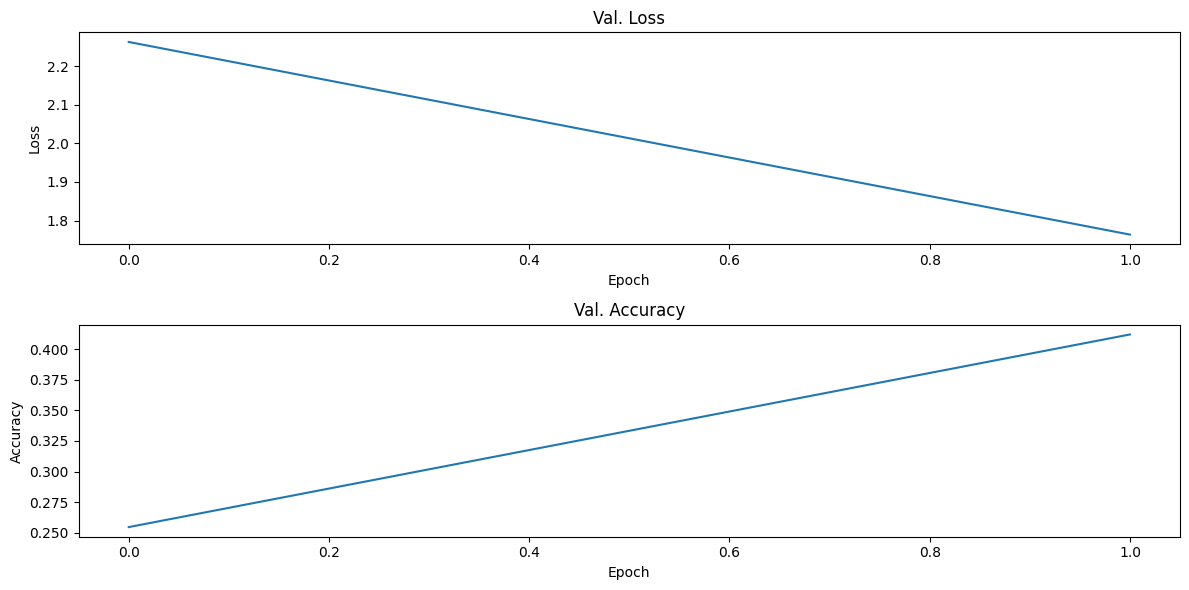

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

1/1 [==============================] - 2s 2s/step


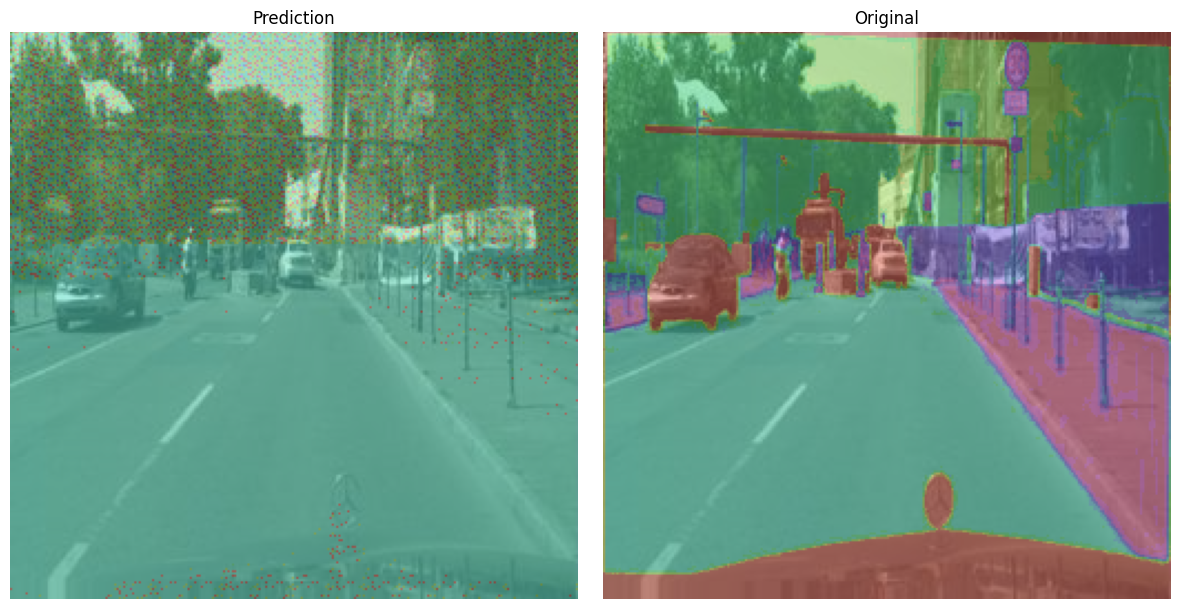

In [ ]:
#val_gen = DataGenerator(valid_folder)
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()